# First bar & pivot points & day High Low - Analytics

### Import Library

In [61]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [62]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [63]:
data = dataset.copy()

In [64]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]

data['Close_9h'] = data['Close']
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h
    })
day_data.dropna(subset=['Close'], inplace=True)

In [65]:
day_data['Pivot'] = day_data.apply(lambda row: (row['High'] + row['Low'] + row['Close']) / 3, axis=1)
day_data['Pivot'] = day_data['Pivot'].shift(1)
day_data['first_open_vs_pivot'] = day_data.apply(lambda r: 1000 * (r['Open'] - r['Pivot']) / r['Open'], axis=1)
day_data['first_close_vs_pivot'] = day_data.apply(lambda r: 1000 * (r['Close_9h'] - r['Pivot']) / r['Close_9h'], axis=1)
day_data['high_vs_pivot'] = 1000 * (day_data['High'] - day_data['High'].shift(1)) / day_data['Pivot']
day_data['low_vs_pivot'] = 1000 * (day_data['Low'] - day_data['Low'].shift(1)) / day_data['Pivot']

In [66]:
day_data

,Open,Close,High,Low,Close_9h,Pivot,first_open_vs_pivot,first_close_vs_pivot,high_vs_pivot,low_vs_pivot
Date,,,,,,,,,,
2018-08-13,943.5,954.2,954.6,942.3,943.1,NaN,NaN,NaN,NaN,NaN
2018-08-14,955.5,959.3,961.8,952.1,954.9,950.366667,5.372405,4.747443,7.576023,10.311809
2018-08-15,958.0,946.6,962.3,946.6,958.7,957.733333,0.278358,1.008310,0.522066,-5.742726
2018-08-16,942.4,947.0,947.3,935.5,942.0,951.833333,-10.009904,-10.438783,-15.759061,-11.661705
2018-08-17,952.2,947.0,954.6,945.0,953.0,943.266667,9.381783,10.213361,7.739063,10.071383
...,...,...,...,...,...,...,...,...,...,...
2024-08-29,1321.1,1326.8,1330.1,1320.6,1321.4,1321.233333,-0.100926,0.126129,4.162777,2.724727
2024-08-30,1328.4,1332.7,1334.9,1328.0,1330.2,1325.833333,1.932149,3.282714,3.620365,5.581395
2024-09-04,1320.8,1314.0,1321.5,1307.3,1318.0,1331.866667,-8.378760,-10.520991,-10.061067,-15.542096


In [67]:
day_data['low_vs_pivot'].describe()

count    1512.000000
mean        0.283687
std        13.850270
min       -69.588501
25%        -5.188841
50%         1.025577
75%         6.915109
max        96.613833
Name: low_vs_pivot, dtype: float64

### Regplot

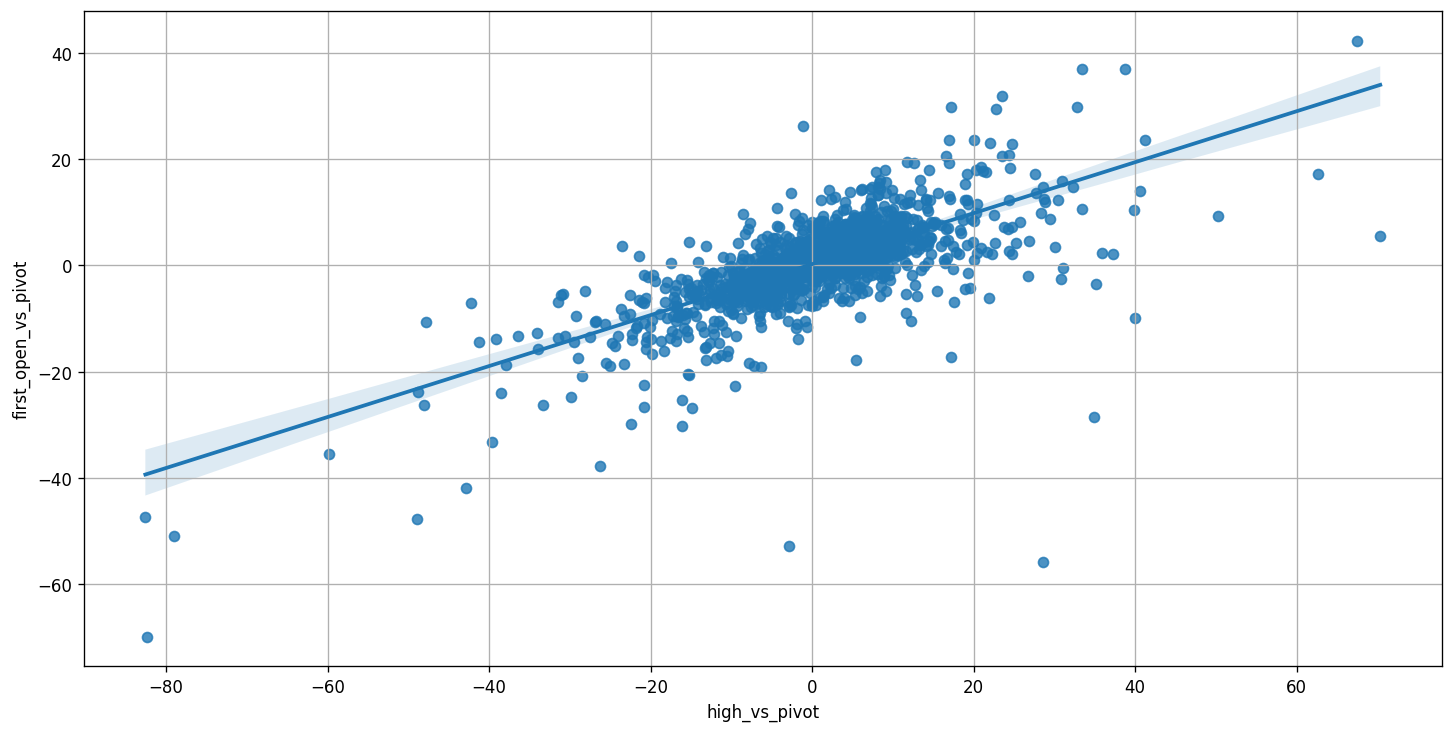

In [68]:
sns.regplot(x=day_data['high_vs_pivot'], y=day_data['first_open_vs_pivot'])
plt.grid(True)

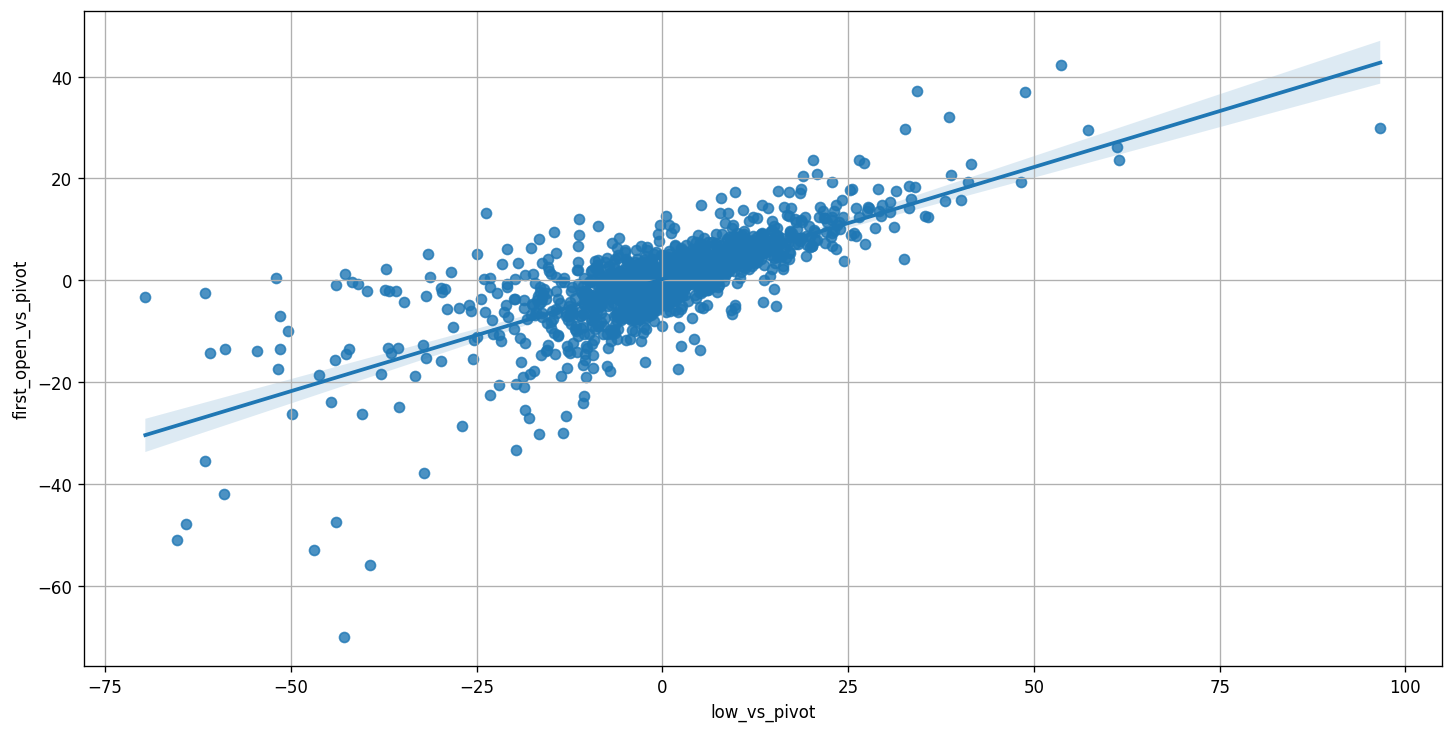

In [69]:
sns.regplot(x=day_data['low_vs_pivot'], y=day_data['first_open_vs_pivot'])
plt.grid(True)

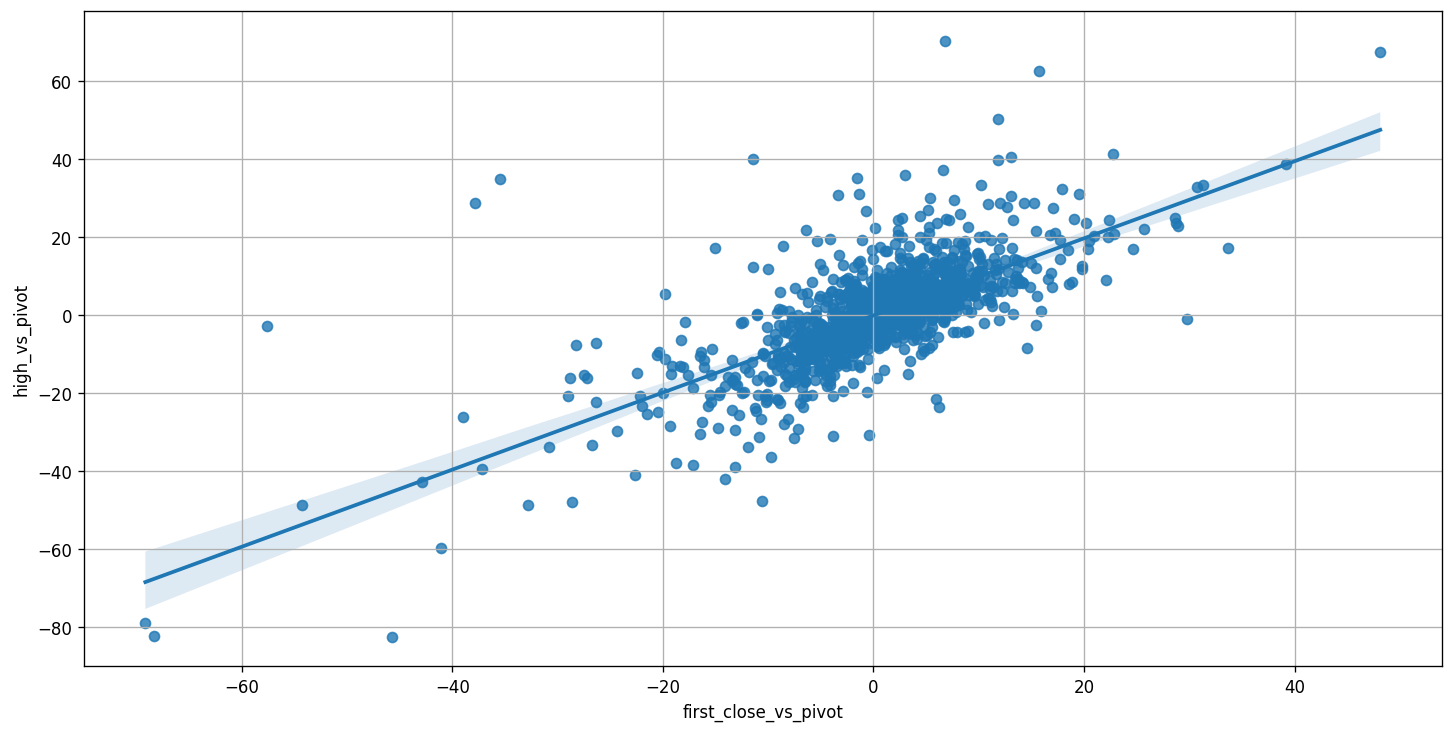

In [70]:
sns.regplot(x=day_data['first_close_vs_pivot'], y=day_data['high_vs_pivot'])
plt.grid(True)

### Heatmap

In [71]:
day_data = day_data[(day_data.first_close_vs_pivot > -20) & (day_data.first_close_vs_pivot < 20) & (day_data.first_open_vs_pivot > -20) & (day_data.first_open_vs_pivot < 20)]
day_data['first_close_vs_pivot_group'] = pd.qcut(day_data.first_close_vs_pivot, 20)
day_data['first_open_vs_pivot_group'] = pd.qcut(day_data.first_open_vs_pivot, 20)

In [72]:
plt.rcParams['figure.figsize'] = [12, 6]

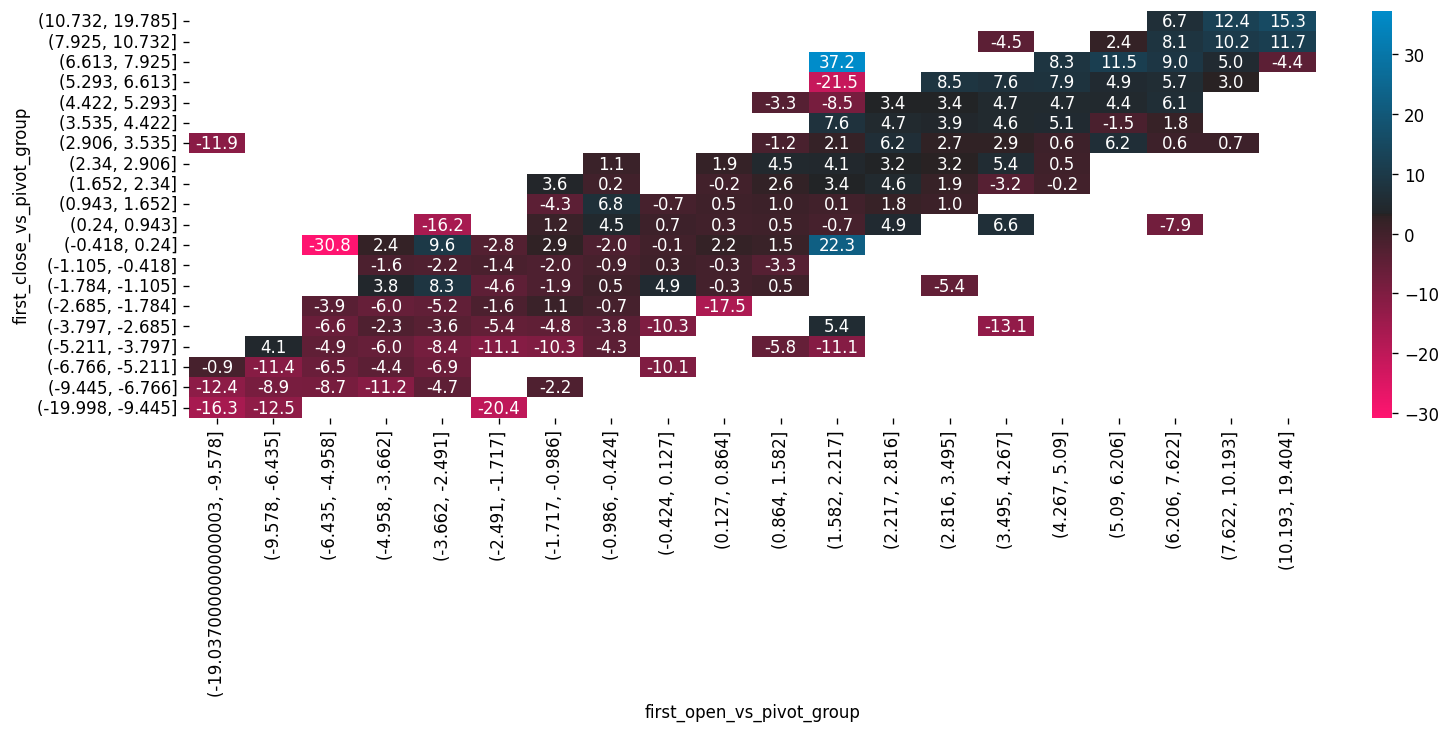

In [73]:
grpd = day_data.groupby(['first_close_vs_pivot_group', 'first_open_vs_pivot_group'])[['high_vs_pivot']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='first_close_vs_pivot_group', columns='first_open_vs_pivot_group', values='high_vs_pivot').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

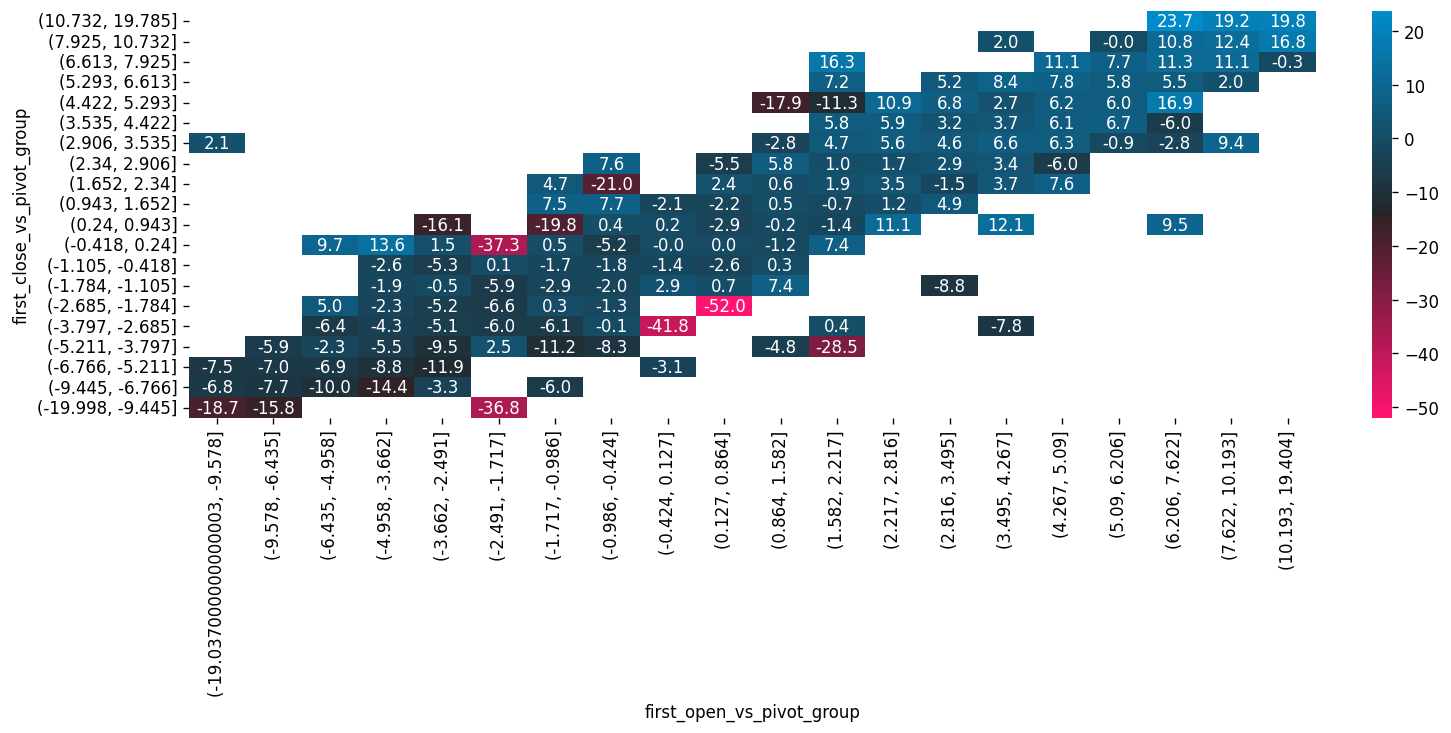

In [74]:
grpd2 = day_data.groupby(['first_close_vs_pivot_group', 'first_open_vs_pivot_group'])[['low_vs_pivot']]
irs = grpd2.mean().reset_index()
sns.heatmap(
    irs.pivot(index='first_close_vs_pivot_group', columns='first_open_vs_pivot_group', values='low_vs_pivot').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

In [75]:
res, bins = pd.qcut(day_data.first_close_vs_pivot, 20, retbins=True)
res.cat.categories.values.tolist()

[Interval(-19.998, -9.445, closed='right'),
 Interval(-9.445, -6.766, closed='right'),
 Interval(-6.766, -5.211, closed='right'),
 Interval(-5.211, -3.797, closed='right'),
 Interval(-3.797, -2.685, closed='right'),
 Interval(-2.685, -1.784, closed='right'),
 Interval(-1.784, -1.105, closed='right'),
 Interval(-1.105, -0.418, closed='right'),
 Interval(-0.418, 0.24, closed='right'),
 Interval(0.24, 0.943, closed='right'),
 Interval(0.943, 1.652, closed='right'),
 Interval(1.652, 2.34, closed='right'),
 Interval(2.34, 2.906, closed='right'),
 Interval(2.906, 3.535, closed='right'),
 Interval(3.535, 4.422, closed='right'),
 Interval(4.422, 5.293, closed='right'),
 Interval(5.293, 6.613, closed='right'),
 Interval(6.613, 7.925, closed='right'),
 Interval(7.925, 10.732, closed='right'),
 Interval(10.732, 19.785, closed='right')]

In [76]:
res.value_counts()

first_close_vs_pivot
(-19.998, -9.445]    73
(0.24, 0.943]        73
(6.613, 7.925]       73
(4.422, 5.293]       73
(2.906, 3.535]       73
(1.652, 2.34]        73
(-9.445, -6.766]     73
(10.732, 19.785]     73
(-1.105, -0.418]     73
(-2.685, -1.784]     73
(-5.211, -3.797]     73
(-0.418, 0.24]       72
(-1.784, -1.105]     72
(2.34, 2.906]        72
(-3.797, -2.685]     72
(3.535, 4.422]       72
(5.293, 6.613]       72
(-6.766, -5.211]     72
(7.925, 10.732]      72
(0.943, 1.652]       72
Name: count, dtype: int64

In [77]:
k = irs.pivot(index='first_close_vs_pivot_group', columns='first_open_vs_pivot_group', values='low_vs_pivot').sort_index(ascending=False)

In [78]:
k.index

CategoricalIndex([ (10.732, 19.785],   (7.925, 10.732],    (6.613, 7.925],
                     (5.293, 6.613],    (4.422, 5.293],    (3.535, 4.422],
                     (2.906, 3.535],     (2.34, 2.906],     (1.652, 2.34],
                     (0.943, 1.652],     (0.24, 0.943],    (-0.418, 0.24],
                   (-1.105, -0.418],  (-1.784, -1.105],  (-2.685, -1.784],
                   (-3.797, -2.685],  (-5.211, -3.797],  (-6.766, -5.211],
                   (-9.445, -6.766], (-19.998, -9.445]],
                 categories=[(-19.998, -9.445], (-9.445, -6.766], (-6.766, -5.211], (-5.211, -3.797], ..., (5.293, 6.613], (6.613, 7.925], (7.925, 10.732], (10.732, 19.785]], ordered=True, dtype='category', name='first_close_vs_pivot_group')

In [79]:
k.columns

CategoricalIndex([(-19.037000000000003, -9.578],              (-9.578, -6.435],
                               (-6.435, -4.958],              (-4.958, -3.662],
                               (-3.662, -2.491],              (-2.491, -1.717],
                               (-1.717, -0.986],              (-0.986, -0.424],
                                (-0.424, 0.127],                (0.127, 0.864],
                                 (0.864, 1.582],                (1.582, 2.217],
                                 (2.217, 2.816],                (2.816, 3.495],
                                 (3.495, 4.267],                 (4.267, 5.09],
                                  (5.09, 6.206],                (6.206, 7.622],
                                (7.622, 10.193],
                               (10.193, 19.404]],
                 categories=[(-19.037000000000003, -9.578], (-9.578, -6.435], (-6.435, -4.958], (-4.958, -3.662], ..., (5.09, 6.206], (6.206, 7.622], (7.622, 10.193], (10.193, 19.40

In [80]:
interval=pd.Interval(-6.773, -5.26)
# k.loc[(k.index>interval.left) & (k.index<=interval.right)]
k.loc[k.index==interval]

first_open_vs_pivot_group,"(-19.037000000000003, -9.578]","(-9.578, -6.435]","(-6.435, -4.958]","(-4.958, -3.662]","(-3.662, -2.491]","(-2.491, -1.717]","(-1.717, -0.986]","(-0.986, -0.424]","(-0.424, 0.127]","(0.127, 0.864]","(0.864, 1.582]","(1.582, 2.217]","(2.217, 2.816]","(2.816, 3.495]","(3.495, 4.267]","(4.267, 5.09]","(5.09, 6.206]","(6.206, 7.622]","(7.622, 10.193]","(10.193, 19.404]"
first_close_vs_pivot_group,,,,,,,,,,,,,,,,,,,,
